In [1]:
!git clone --depth 1 https://github.com/borea17/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 98 (delta 0), reused 97 (delta 0), pack-reused 0
Unpacking objects: 100% (98/98), done.
Checking out files: 100% (91/91), done.


In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms


def load_dataset():
    num_img, img_size = 30, 512
    # initialize
    imgs = torch.zeros(num_img, 1, img_size, img_size)
    labels = torch.zeros(num_img, 1, img_size, img_size)
    # fill tensors with data
    for index in range(num_img):
        cur_name = str(index) + '.png'
        
        img_frame = Image.open('./Datasets/EM_2012/train/image/' + cur_name)
        label_frame = Image.open('./Datasets/EM_2012/train/label/' + cur_name)
        
        imgs[index] = transforms.ToTensor()(img_frame).type(torch.float32)
        labels[index] = transforms.ToTensor()(label_frame).type(torch.float32)
    return imgs, labels


imgs, labels = load_dataset()

In [3]:
from torch.utils.data import Dataset
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.signal import convolve2d
import torchvision.transforms.functional as TF


class EM_Dataset(Dataset):
    """EM Dataset (from ISBI 2012) to train U-Net on including data 
    augmentation as proposed by Ronneberger et al. (2015)
    
    Args:
        imgs (tensor): torch tensor containing input images [1, 512, 512]
        labels (tensor): torch tensor containing segmented images [1, 512, 512]
        stride (int): stride that is used for overlap-tile strategy,
            Note: stride must be chosen such that all labels are retrieved
        transformation (bool): transform should be applied (True) or not (False)
    ------- transformation related -------
        probability (float): probability that transformation is applied
        alpha (float): intensity of elastic deformation
        sigma (float): std dev. of Gaussian kernel, i.e., smoothing parameter 
        kernel dim (int): kernel size is [kernel_dim, kernel_dim]
    """
    
    def __init__(self, imgs, labels, stride, transformation=False, 
                 probability=None, alpha=None, sigma=None, kernel_dim=None):
        super().__init__()
        assert isinstance(stride, int) and stride <= 124 and \
          round((512-388)/stride) == (512-388)/stride 
        self.orig_imgs = imgs
        self.imgs = EM_Dataset._extrapolate_by_mirroring(imgs)
        self.labels = labels
        self.stride = stride
        self.transformation = transformation
        if transformation:
            assert 0 <= probability <= 1
            self.probability = probability 
            self.alpha = alpha
            self.kernel = EM_Dataset._create_gaussian_kernel(kernel_dim, sigma)
        return
      
    def __getitem__(self, index):
        """images and labels are divided into several overlaping parts using the 
        overlap-tile strategy        
        """
        number_of_tiles_1D = (1 + int((512 - 388)/self.stride))
        number_of_tiles_2D = number_of_tiles_1D**2
        
        img_index = int(index/number_of_tiles_2D)
        # tile indexes of image
        tile_index = (index % number_of_tiles_2D)
        tile_index_x = (tile_index % number_of_tiles_1D) * self.stride
        tile_index_y = int(tile_index / number_of_tiles_1D) * self.stride
        
        img = self.imgs[img_index, :,
                        tile_index_y:tile_index_y + 572, 
                        tile_index_x:tile_index_x + 572]
        label = self.labels[img_index, :, 
                            tile_index_y: tile_index_y + 388, 
                            tile_index_x: tile_index_x + 388]
        if self.transformation:
            if np.random.random() > 1 - self.probability:
                img, label = EM_Dataset.elastic_deform(img, label, self.alpha,
                                                       self.kernel)
        return (img, label)
      
    def __len__(self):
        number_of_imgs = len(self.imgs)
        number_of_tiles = (1 + int((512 - 388)/self.stride))**2
        return number_of_imgs * number_of_tiles
      
    @staticmethod
    def gray_value_variations(image, sigma):
        """applies gray value variations by adding Gaussian noise
        
        Args:
            image (torch tensor): extrapolated image tensor [1, 572, 572]
            sigma (float): std. dev. of Gaussian distribution
        
        Returns:
            image (torch tensor): image tensor w. gray value var. [1, 572, 572]
        """
        # see https://stats.stackexchange.com/a/383976
        noise = torch.randn(image.shape, dtype=torch.float32) * sigma
        return image + noise
     
    @staticmethod
    def affine_transform(image, label, angle, translate):
        """applies random affine translations and rotation on image and label 
               
        Args:
            image (torch tensor): extrapolated image tensor [1, 572, 572]
            label (torch tensor): label tensor [1, 388, 388]
            angle (float): rotation angle
            translate (list): entries correspond to horizontal and vertical shift
            
        Returns:
            image (torch tensor): transformed image tensor [1, 572, 572]
            label (torch tensor): transformed label tensor [1, 388, 388]        
        """
        # transform to PIL
        image = transforms.ToPILImage()(image[0])
        label = transforms.ToPILImage()(label[0])
        # apply affine transformation
        image = TF.affine(image, angle=angle, translate=translate, 
                          scale=1, shear=0)
        label = TF.affine(label, angle=angle, translate=translate, 
                          scale=1, shear=0)
        # transform back to tensor
        image = transforms.ToTensor()(np.array(image))
        label = transforms.ToTensor()(np.array(label))
        return image, label
    
    @staticmethod
    def elastic_deform(image, label, alpha, gaussian_kernel):
        """apply smooth elastic deformation on image and label data as 
        described in
        
        [Simard2003] "Best Practices for Convolutional Neural Networks applied
        to Visual Document Analysis"
        
        Args: 
            image (torch tensor): extrapolated image tensor [1, 572, 572]
            label (torch tensor): label tensor [1, 388, 388]
            alpha (float): intensity of transformation
            gaussian_kernel (np array): gaussian kernel used for smoothing
            
        Returns:
            deformed_img (torch tensor): deformed image tensor [1, 572, 572]
            deformed_label (torch tensor): deformed label tensor [1, 388, 388]
        
        code is adapted from https://github.com/vsvinayak/mnist-helper
        """
        # generate standard coordinate grids
        x_i, y_i = np.meshgrid(np.arange(572), np.arange(572))
        x_l, y_l = np.meshgrid(np.arange(388), np.arange(388))
        # generate random displacement fields (uniform distribution [-1, 1])
        dx = 2*np.random.rand(*x_i.shape) - 1
        dy = 2*np.random.rand(*y_i.shape) - 1
        # smooth by convolving with gaussian kernel 
        dx = alpha * convolve2d(dx, gaussian_kernel, mode='same')
        dy = alpha * convolve2d(dy, gaussian_kernel, mode='same')
        # one dimensional coordinates (neccessary for map_coordinates)
        x_img = np.reshape(x_i + dx, (-1, 1))
        y_img = np.reshape(y_i + dy, (-1, 1))
        x_label = np.reshape(x_l + dx[92:480, 92:480], (-1, 1))
        y_label = np.reshape(y_l + dy[92:480, 92:480], (-1, 1))
        # deformation using map_coordinates interpolation (spline not bicubic)
        deformed_img = map_coordinates(image[0], [y_img, x_img], order=1, 
                                       mode='reflect')
        deformed_label = map_coordinates(label[0], [y_label, x_label], order=1,
                                         mode='reflect')
        # reshape into desired shape and cast to tensor
        deformed_img = torch.from_numpy(deformed_img.reshape(image.shape))
        deformed_label = torch.from_numpy(deformed_label.reshape(label.shape))
        return deformed_img, deformed_label
    
    @staticmethod
    def _extrapolate_by_mirroring(data):
        """increase data by mirroring (needed for overlap-tile strategy)
        
        Args:
            data (torch tensor): shape [num_samples, 1, 512, 512]
            
        Returns:
            extrapol_data (torch tensor): shape [num_samples, 1, 696, 696]
        """
        num_samples = len(data)
        extrapol_data = torch.zeros(num_samples, 1, 696, 696)
        
        # put data into center of extrapol data
        extrapol_data[:,:, 92:92+512, 92:92+512] = data
        # mirror left
        extrapol_data[:,:, 92:92+512, 0:92] = data[:,:,:,0:92].flip(3)
        # mirror right
        extrapol_data[:,:, 92:92+512, 92+512::] = data[:,:,:,-92::].flip(3)
        # mirror top
        extrapol_data[:,:, 0:92,:] = extrapol_data[:,:,92:92+92,:].flip(2)
        # mirror buttom
        extrapol_data[:,:, 92+512::,:] = extrapol_data[:,:, 512:512+92,:].flip(2)
        return extrapol_data
    
    @staticmethod
    def _create_gaussian_kernel(kernel_dim, sigma):
        """returns a 2D Gaussian kernel with the standard deviation
        denoted by sigma
        
        Args:
            kernel_dim (int): kernel size will be [kernel_dim, kernel_dim]
            sigma (float): std dev of Gaussian (smoothing parameter)
            
        Returns:
            gaussian_kernel (numpy array): centered gaussian kernel
            
        code is adapted from https://github.com/vsvinayak/mnist-helper
        """
        # check if the dimension is odd
        if kernel_dim % 2 == 0:
            raise ValueError("Kernel dimension should be odd")
        # initialize the kernel
        kernel = np.zeros((kernel_dim, kernel_dim), dtype=np.float16)
        # calculate the center point
        center = kernel_dim/2
        # calculate the variance
        variance = sigma ** 2
        # calculate the normalization coefficeint
        coeff = 1. / (2 * variance)
        # create the kernel
        for x in range(0, kernel_dim):
            for y in range(0, kernel_dim):
                x_val = abs(x - center)
                y_val = abs(y - center)
                numerator = x_val**2 + y_val**2
                denom = 2*variance
            
                kernel[x,y] = coeff * np.exp(-1. * numerator/denom)
        # normalise it
        return kernel/sum(sum(kernel))


# generate datasets   
stride = 124
whole_dataset = EM_Dataset(imgs, labels, stride=stride, 
                           transformation=True, probability=0.5, alpha=50, 
                           sigma=5, kernel_dim=25)

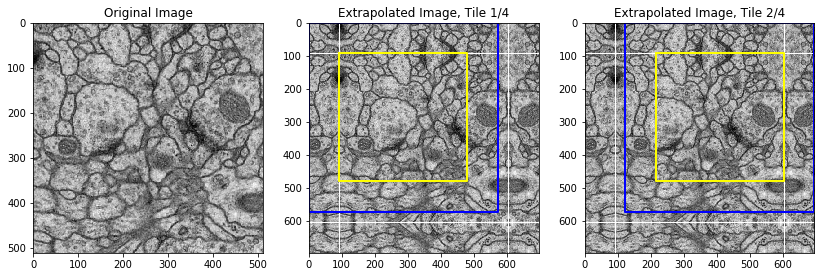

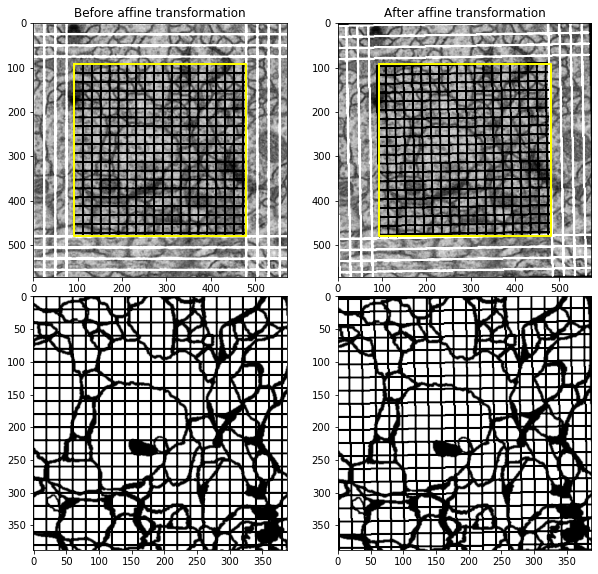

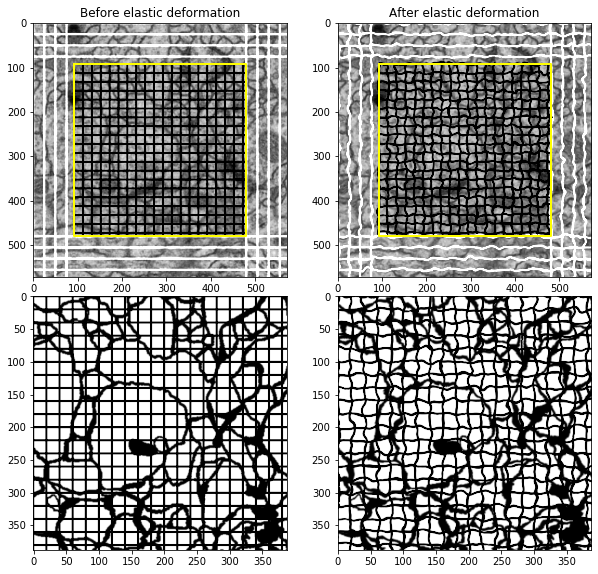

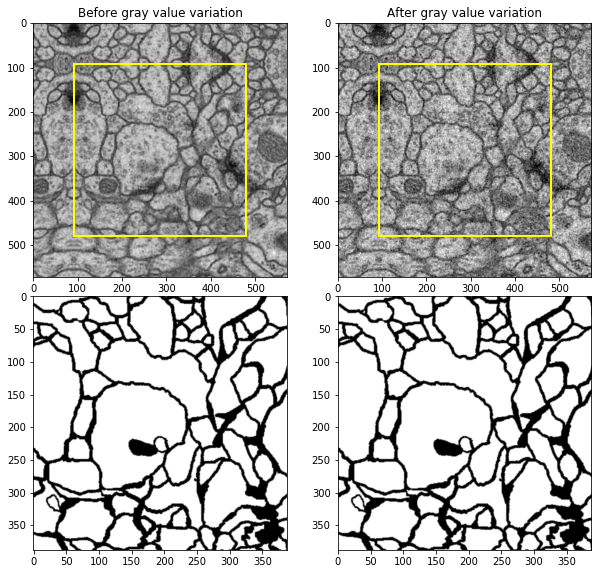

In [4]:
import matplotlib.pyplot as plt


def visualize_overlap_tile_strategy(dataset, img_index, tile_indexes):
    # compute tiling data
    number_of_tiles_1D = (1 + int((512 - 388)/dataset.stride))
    number_of_tiles_2D = number_of_tiles_1D**2
    # original image [1, 512, 512]
    orig_img = dataset.orig_imgs[img_index]
    # extrapolated image [1, 696, 696]
    extrapol_img = dataset.imgs[img_index]
    
    
    # start plotting
    fig = plt.figure(figsize=(14, 7))
    # original image 
    plt.subplot(1, len(tile_indexes) + 1, 1)
    plt.imshow(transforms.ToPILImage()(orig_img), cmap='gray')
    plt.title('Original Image')
    # extrapolated image with bounding boxes and mirror lines for tile_indexes
    for index, tile_index in enumerate(tile_indexes):
        plt.subplot(1, len(tile_indexes) + 1, 2 + index)
        plt.imshow(transforms.ToPILImage()(extrapol_img), cmap='gray')
        # calculate tile index x and y 
        tile_ix = (tile_index % number_of_tiles_1D) * dataset.stride
        tile_iy = int(tile_index / number_of_tiles_1D) * dataset.stride
        # add focus of current input tile
        plt.plot([tile_ix, tile_ix + 572, tile_ix + 572, tile_ix, tile_ix], 
                 [tile_iy, tile_iy, tile_iy + 572, tile_iy + 572, tile_iy],
                 'blue', linewidth=2)
        # add focus of current segmentation mask
        tile_ix, tile_iy = tile_ix + 92, tile_iy + 92
        plt.plot([tile_ix, tile_ix + 388, tile_ix + 388, tile_ix, tile_ix], 
                 [tile_iy, tile_iy, tile_iy + 388, tile_iy + 388, tile_iy],
                 'yellow', linewidth=2)
        # add mirror lines
        plt.vlines([92, 604], 0, 696, 'white', linewidth=1)
        plt.hlines([92, 604], 0, 696, 'white', linewidth=1)
        plt.title('Extrapolated Image, Tile '+ str(tile_index + 1) + '/' + 
                  str(number_of_tiles_2D))
        plt.xlim(0, 696)
        plt.ylim(696, 0)
    return


def visualize_data_augmentation(dataset, index, show_grid, kind):
    # get untransformed img, label
    dataset.transformation = False
    img, label = dataset[index]
    # copy image (since it may be modified)
    cur_img = img.clone().numpy()
    cur_label = label.clone().numpy()
    if show_grid:
        # modify image to include outer grid (outside of label)
        cur_img[0, 0:91:25] = 10.0
        cur_img[0, 480::25] = 10.0
        cur_img[0, :, 0:91:25] = 10.0
        cur_img[0, :, 480::25] = 10.0
        # modify image to include label grid
        cur_img[0, 92:480:20, 92:480] = -5
        cur_img[0,  92:480, 92:480:20] = -5
        # modify label to include label grid
        cur_label[0, ::20] = -5
        cur_label[0, :, ::20] = -5
    if kind == 'elastic deformation':
        # set transformation
        kernel = dataset.kernel
        alpha = dataset.alpha
        new_img, new_label = EM_Dataset.elastic_deform(cur_img, cur_label,
                                                       alpha, kernel)
    elif kind == 'affine transformation':
        angle = np.random.randint(-3, 3)
        translate = list(np.random.randint(-3, 3, size=2))
        new_img, new_label = EM_Dataset.affine_transform(cur_img, cur_label,
                                                         angle, translate)
    elif kind == 'gray value variation':
        sigma = 0.2
        new_img = EM_Dataset.gray_value_variations(img, sigma)
        new_label = label
    else:
        raise NameError('Unknown `kind`, can only be `elastic deformation`, ' +
                        '`affine transformation` or `gray value variation`')
    # start plotting
    fig = plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)
    plt.title('Before ' + kind)
    plt.imshow(cur_img[0], cmap='gray', aspect='equal', 
               interpolation='gaussian', vmax=1, vmin=0)
    # focus of current segmentation mask
    plt.plot([92, 480, 480, 92, 92], [92, 92, 480, 480, 92],
            'yellow', linewidth=2)
    plt.subplots_adjust(hspace=0.01)
    plt.subplot(2,2,3)
    plt.imshow(cur_label[0], cmap='gray', aspect='equal', 
               interpolation='gaussian', vmax=1, vmin=0)
    plt.subplot(2,2,2)
    plt.title('After ' + kind)
    plt.imshow(new_img[0], cmap='gray', aspect='equal', 
               interpolation='gaussian', vmax=1, vmin=0)
    # focus of current segmentation mask
    plt.plot([92, 480, 480, 92, 92], [92, 92, 480, 480, 92],
            'yellow', linewidth=2)
    plt.subplot(2,2,4)
    plt.imshow(new_label[0], cmap='gray', aspect='equal', 
               interpolation='gaussian', vmax=1, vmin=0)
    return


# generate images in order of appearance
visualize_overlap_tile_strategy(whole_dataset, img_index=0, 
                                tile_indexes=[0, 1])
visualize_data_augmentation(whole_dataset, index=0, show_grid=True, 
                            kind='affine transformation')
visualize_data_augmentation(whole_dataset, index=0, show_grid=True, 
                            kind='elastic deformation')
visualize_data_augmentation(whole_dataset, index=0, show_grid=False, 
                            kind='gray value variation')

In [5]:
from torch import nn


class Unet(nn.Module):
    """original U-Net architecture proposed by Ronneberger et al. (2015)

    Attributes:
        encoder_blocks (list):  four u_net blocks of encoder path
        bottleneck_bock: block that mediates between encoder and decoder
        decoder_blocks (list):  four u_net blocks of decoder path
        cropped_img_size (list): cropped images size in order of encoder blocks 
        up_convs (list): upsampling (transposed convolutional) layers (decoder)
        max_pool: max pool operation used in encoder path
    """

    def __init__(self):
        super().__init__()
        self.encoder_blocks = nn.ModuleList([
            Unet._block(1, 64),
            Unet._block(64, 128),
            Unet._block(128, 256),
            Unet._block(256, 512)
        ])
        self.bottleneck_block = Unet._block(512, 1024)
        self.decoder_blocks = nn.ModuleList([
            Unet._block(1024, 512),
            Unet._block(512, 256),
            Unet._block(256, 128),
            Unet._block(128, 64)
        ])
        self.cropped_img_sizes = [392, 200, 104, 56]
        self.up_convs = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=(2,2), stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=(2,2), stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=(2,2), stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=(2,2), stride=2),
        ])
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2))
        self.prediction = nn.Conv2d(64, 2, kernel_size=(1,1), stride=1)
        return

    def forward(self, x):
        # go through encoder path and store cropped images
        cropped_imgs = []
        for index, encoder_block in enumerate(self.encoder_blocks):
            out = encoder_block(x)
            # center crop and add to cropped image list
            cropped_img = Unet._center_crop(out, self.cropped_img_sizes[index])
            cropped_imgs.append(cropped_img)
            # max pool output of encoder block
            x = self.max_pool(out)
        # bottleneck block (no max pool)
        x = self.bottleneck_block(x)  # [batch_size, 1024, 28, 28]
        # go through decoder path with stored cropped images
        for index, decoder_block in enumerate(self.decoder_blocks):
            x = self.up_convs[index](x)
            # concatenate x and cropped img along channel dimension
            x = torch.cat((cropped_imgs[-1-index], x), 1)
            # feed through decoder_block
            x = decoder_block(x)
        # feed through prediction layer [batch_size, 2, 388, 388]
        x_pred_unnormalized = self.prediction(x)
        # normalize prediction for each pixel
        x_pred = torch.softmax(x_pred_unnormalized, 1)
        return x_pred

    @staticmethod
    def _center_crop(x, new_size):
        """center croping of a square input tensor

        Args:
            x: input tensor shape [batch_size, channels, resolution, resolution]
            new_size: the desired output resolution (taking center of input)

        Returns:
            x_cropped: tensor shape [batch_size, channels, new_size, new_size]
        """
        img_size = x.shape[-1]
        i_start = int((img_size - new_size)/2)
        i_end = int((img_size + new_size)/2)
        x_cropped = x[:, :, i_start:i_end, i_start:i_end]
        return x_cropped

    @staticmethod
    def _block(in_channels, out_channels):
        """block for use in U-Net architecture,
        consists of two conv 3x3, ReLU layers

        Args:
            in_channels: number of input channels for first convolution
            out_channels: number of output channels for both convolutions

        Returns:
            u_net_block: Sequential U net block
        """
        conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1)
        conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1)

        N_1, N_2 = 9*in_channels, 9*out_channels
        # initialize by drawing weights from Gaussian distribution
        conv1.weight.data.normal_(mean=0, std=np.sqrt(2/N_1))
        conv2.weight.data.normal_(mean=0, std=np.sqrt(2/N_2))
        # define u_net_block
        u_net_block = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
            nn.ReLU()
        )
        return u_net_block

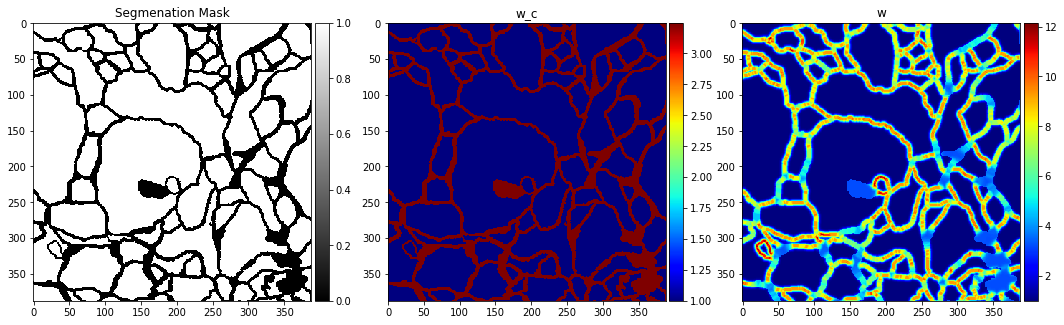

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import measure
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import find_boundaries


def compute_weight_map(label_mask, w_0, sigma, plot=False):
    """compute weight map for each ground truth segmentation to compensate
    for the different class frequencies and to put additional
    emphasis on small borders as proposed by Ronneberger et al.

    Args:
        label mask (torch tensor): true segmentation masks [batch_size, 1, 388, 388]
        w_0 (float): hyperparameter in second term of weight map
        sigma (float): hyperparameter in second term of weight map

    Returns:
        weight_map (torch tensor): computed weight map [batch_size, 1, 388, 388]
      
    researchgate.net/post/creating_a_weight_map_from_a_binary_image_U-net_paper
    """
    batch_size = label_mask.shape[0]
    weight_map = torch.zeros_like(label_mask)
    for i in range(batch_size):
        # compute w_c to balance class frequencies
        w_c = label_mask[i][0].clone()
        class_freq_0 = (label_mask[i]==0).sum().item()
        class_freq_1 = (label_mask[i]==1).sum().item()
        w_c[label_mask[i][0]==0] = class_freq_1 / class_freq_0
        # compute d_1, d_2, i.e., euclid. dist. to border of (1st/2nd) closest cell
        d_1 = np.zeros(label_mask[i][0].shape)
        d_2 = np.zeros(label_mask[i][0].shape)
        # distinguish all cells (connected components of ones)
        all_cells = measure.label(label_mask[i][0], background=0, connectivity=2)
        num_cells = np.max(all_cells)
        # initialize distances for all cells 
        dists = np.zeros([num_cells, d_2.shape[0], d_2.shape[1]])
        # iterate over all zero components
        for index, i_cell in enumerate(range(1, num_cells + 1)):
            # cell segmentation (segmented cell 1, rest 0)
            cell_segmentation = all_cells==i_cell
            # find boundary (boundary 1, rest 0)
            boundary = find_boundaries(cell_segmentation, mode='inner')
            # compute distance to boundary (set boundary 0, rest -1)
            bound_dists = distance_transform_edt(1 - boundary)
            dists[index] = bound_dists
        # sort dists along first axis (each pixel)
        dists.sort(axis=0)
        d_1 = dists[0]
        d_2 = dists[1]
        w = w_c + w_0 * np.exp(- (d_1 + d_2)**2/(2*sigma**2))
        # save w to weight map
        weight_map[i, 0] = w

        # visualize weight map 
        if plot and i==0:
            fig = plt.figure(figsize=(18, 14))

            ax = plt.subplot(1, 3, 1)
            plt.title('Segmenation Mask')
            plt.imshow(label_mask[0, 0], cmap='gray')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(cax=cax)

            ax = plt.subplot(1, 3, 2)
            plt.title('w_c')
            plt.imshow(w_c, cmap='jet')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(cax=cax)


            ax = plt.subplot(1, 3, 3)
            plt.title('w')
            plt.imshow(w, cmap='jet')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(cax=cax)
    return weight_map


img, label_mask = whole_dataset[0]
weight_map = compute_weight_map(label_mask.unsqueeze(0), w_0=10, sigma=5, plot=True)

In [7]:
from livelossplot import PlotLosses
from torch.utils.data import DataLoader


def train(u_net, dataset, epochs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # hyperparameters weight map
    w_0, sigma = 10, 5

    print('Device: {}'.format(device))

    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    u_net.to(device)
    optimizer = torch.optim.SGD(u_net.parameters(), lr=0.001, momentum=0.99)

    losses_plot = PlotLosses()
    for epoch in range(epochs):
        avg_loss = 0
        for counter, (imgs, label_masks) in enumerate(data_loader):
            u_net.zero_grad()
            # retrieve predictions of u_net [batch, 2, 388, 388]
            pred_masks = u_net(imgs.to(device))
            # compute weight map
            weight_map = compute_weight_map(label_masks, w_0, sigma).to(device)
            # put label_masks to device
            label_masks = label_masks.to(device)
            # compute weighted binary cross entropy loss
            loss = -(weight_map*
                    (pred_masks[:, 0:1].log() * label_masks +
                      pred_masks[:, 1:2].log() * (1 - label_masks))
                    ).mean()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(dataset)

            losses_plot.update({'current weighted loss': loss.item()},
                              current_step=epoch + counter/len(data_loader))
            losses_plot.draw()
        losses_plot.update({'avg weighted loss': avg_loss}, 
                          current_step=epoch + 1)
        losses_plot.draw()
    trained_u_net = u_net
    return trained_u_net

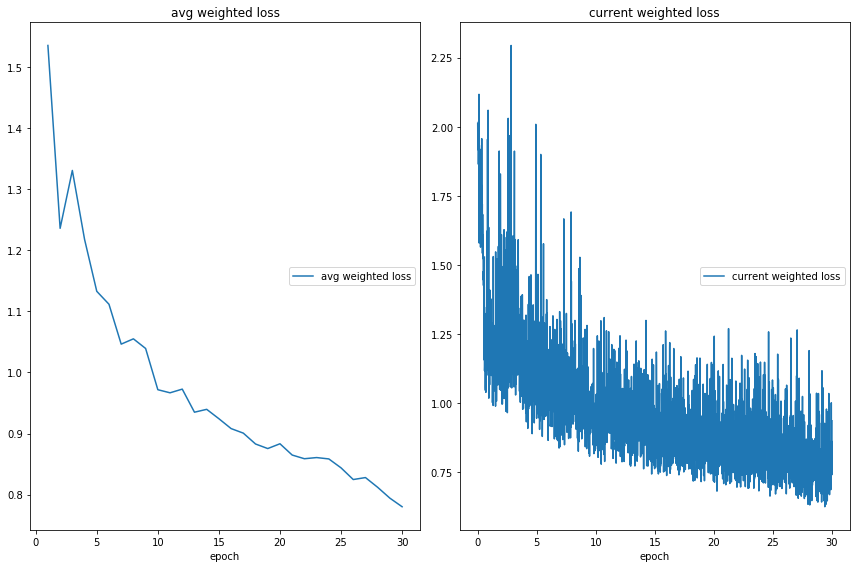

avg weighted loss
	avg weighted loss 	 (min:    0.780, max:    1.535, cur:    0.780)
current weighted loss
	current weighted loss 	 (min:    0.626, max:    2.294, cur:    0.937)


In [8]:
u_net = Unet()
epochs = 30
# all image indexes
idx = np.arange(30)
# random inplace shuffling of indexes
np.random.seed(1)
np.random.shuffle(idx)
# split data into training and test data
train_imgs, train_labels = imgs[idx[0:25]], labels[idx[0:25]]
test_imgs, test_labels = imgs[idx[25:]], labels[idx[25:]]
# generate datasets   
stride = 124
train_dataset = EM_Dataset(train_imgs, train_labels, stride=stride, 
                          transformation=True, probability=0.7, alpha=50, 
                          sigma=5, kernel_dim=25)
test_dataset = EM_Dataset(test_imgs, test_labels, stride=stride, 
                          transformation=False)
# start training procedure 
trained_u_net = train(u_net, train_dataset, epochs)

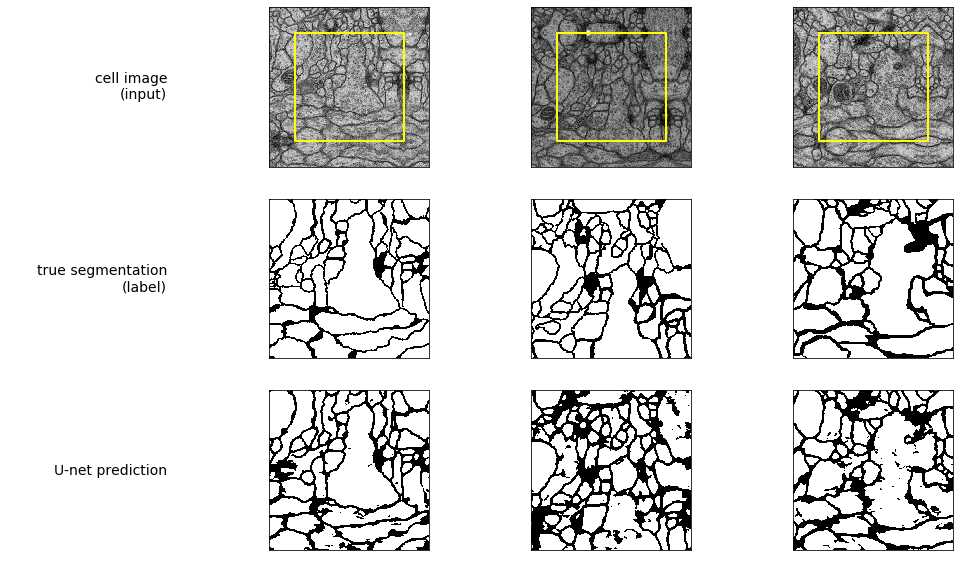

In [9]:
def visualize_results(trained_u_net, test_dataset, num_test_images=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # take random tile from each test image
    num_tiles = (1 + int((512 - 388)/test_dataset.stride))**2
    num_images = int(len(test_dataset) / num_tiles)
    if num_test_images:
        # number of images < number of images in test set
        num_images = min(num_test_images, num_images)
    random_tile_idx = np.random.choice(range(num_tiles), num_images, 
                                       replace=True)
    
    fig = plt.figure(figsize=(num_images*6, 10))
    # annotation plots
    ax = plt.subplot(3, num_images + 1, 1)
    ax.annotate('cell image\n(input)', xy=(1, 0.5), xycoords='axes fraction',
                 fontsize=14, va='center', ha='right')
    ax.set_aspect('equal')
    ax.axis('off')
    ax = plt.subplot(3, num_images + 1, num_images + 2)
    ax.annotate('true segmentation\n(label)', xy=(1, 0.5), 
                xycoords='axes fraction', fontsize=14, va='center', ha='right')
    ax.set_aspect('equal')
    ax.axis('off')
    ax = plt.subplot(3, num_images + 1, 2*(num_images + 1) + 1)
    ax.annotate('U-net prediction', xy=(1, 0.5), xycoords='axes fraction',
                 fontsize=14, va='center', ha='right')
    ax.set_aspect('equal')
    ax.axis('off')
    # image, label, predicted label plots
    for index in range(num_images):
        img, label = test_dataset[index*num_tiles + random_tile_idx[index]]
        label_pred = u_net(img.unsqueeze(0).to(device)).squeeze(0)[0] > 0.5
        
        # plot original image
        plt.subplot(3, num_images + 1, index + 2)
        plt.imshow(transforms.ToPILImage()(img), cmap='gray')
        plt.plot([92, 480, 480, 92, 92], [92, 92, 480, 480, 92],
                 'yellow', linewidth=2)
        plt.xticks([])
        plt.yticks([])
        # plot original segmentation mask
        plt.subplot(3, num_images + 1, index + num_images + 3)
        plt.imshow(transforms.ToPILImage()(label), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # plot prediction segmentation mask
        plt.subplot(3, num_images + 1, index + 2*(num_images + 1) + 2)
        plt.imshow(label_pred.detach().cpu().numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    return


visualize_results(trained_u_net, test_dataset, num_test_images=3)